# rSLDS - Hangry Mice

This notebook allows for 2-dimensional models

## Set up environment

### Packages and helper functions

In [14]:
# Packages
import sklearn
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

from scipy.io import loadmat
from scipy.io import savemat

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
%matplotlib inline
# %matplotlib notebook

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d

In [15]:
# Colors for plotting
# color_names = ["windows blue",
#                "red",
#                "amber",
#                "faded green",
#                "dusty purple",
#                "orange",
#                "clay",
#                "pink",
#                "greyish",
#                "mint",
#                "cyan",
#                "steel blue",
#                "forest green",
#                "pastel purple",
#                "salmon",
#                "dark brown",
#                "goldenrod"]
# colors = sns.xkcd_palette(color_names)

color_names = ["red",
               "windows blue",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

# save_figures = False

# Specify colors for plotting behaviors
color_names_beh = ["light grey",
                   "red",
                   "orange",
                   "faded green",
                   "windows blue"]
colors_beh = sns.xkcd_palette(color_names_beh)
cmap_beh = ListedColormap(colors_beh)


In [16]:
# Helper functions for plotting results
def plot_trajectory(z, x,a1,a2,ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, a1],
                x[start:stop + 1, a2],
                lw=1, ls=ls,
                color=colors_state_dynamics[z[start] % len(colors_state_dynamics)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0]+1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax

def plot_trajectory_beh(z, x, a1, a2, ax=None, alpha=1, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0]+1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, a1],
                x[start:stop + 1, a2],
                lw=1, ls=ls,
                color=
                colors_traj[z[start] % len(colors_traj)],
                alpha=alpha)
    return ax

def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy
        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors_state_dynamics[k % len(colors_state_dynamics)], alpha=alpha)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

def plot_most_likely_dynamics_state(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        if k == 2:
            varAs = model.dynamics.As
            varbs = model.dynamics.bs
            dxydt_m = xy.dot(varAs[1].T) + varbs[1] - xy

            zk = z == k
            if zk.sum(0) > 0:
                ax.quiver(xy[zk, 0], xy[zk, 1],
                        dxydt_m[zk, 0], dxydt_m[zk, 1],
                        color=colors_state_dynamics[1 % len(colors_state_dynamics)], alpha=alpha)
 
        else:
                
            zk = z == k
            if zk.sum(0) > 0:
                ax.quiver(xy[zk, 0], xy[zk, 1],
                        dxydt_m[zk, 0], dxydt_m[zk, 1],
                        color=colors_state_dynamics[k % len(colors_state_dynamics)], alpha=alpha)


    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

def plot_state_pie(zhat_lem, model, statedatapy, figsize=(55,10)):
    fig = plt.figure(figsize=figsize)

    beh_labels = ["None", "Attack", "Eating", "Food Sniff", "Sniff Male"]
    c = 1 # initialize plot counter

    for i in range(0, model.K):
        x = np.where(zhat_lem == i)
        state_vals = statedatapy[x]
        state_vals= np.bincount(state_vals)
        plt.subplot(1, model.K, c)
        # plt.pie(state_vals, autopct="%1.0f%%", labels=beh_labels[0:state_vals.size], pctdistance=0.55,labeldistance=1.1, colors = colors_beh)
        plt.pie(state_vals, autopct="%1.0f%%", pctdistance=1.3, labeldistance=1.1, colors=colors_beh)

        # pie_beh[0][:].set_alpha
        # Draw circle
        centre_circle = plt.Circle((0,0), 0.70, fc='white')
        fig.gca().add_artist(centre_circle)

        plt.title('State ' + str(i+1) + ' ' + color_names[i])
        c = c + 1

### Import data

In [111]:
# Import data, states: annotations, neural data: ca traces
# Behavior index:
# 0: no beh, 1: attack, 2: eating, 3: food_sniff, 4: sniffM
# neuraldata is a NxT matrix of calcium activity
# vmhdata = loadmat('data/EG1-1_fasted_unreg_rSLDS.mat') # Unregistered data for EG1-1, fasted
vmhdata = loadmat('data/EG1-4_fasted_unreg_male1_rSLDS.mat') # Unregistered data for EG1-4, fasted (first male interaction)
neuraldata = np.transpose(vmhdata['neuralDataPreprocessed'])
statedata = vmhdata['collapsedBehaviorData']
statedatapy = statedata[0,:]

In [18]:
# neuraldata = neuraldata[1000:4500, :]
# statedatapy = statedatapy[1000:4500]

In [19]:
vmhdataM1 = loadmat('data/EG1-1_fasted_unreg_rSLDS.mat')
neuraldataM1 = np.transpose(vmhdataM1['neuralDataPreprocessed'])
statedataM1 = vmhdataM1['collapsedBehaviorData']
statedatapyM1 = statedataM1[0,:]

#### Define average activity clusters

In [20]:
# Cluster labels for EG1-4, fasted, co-registered
cluster_labels_fasted = np.array([0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 4, 4, 4, 0, 4, 4, 3, 2, 2,
                                  2, 1, 2, 0, 0, 0, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,
                                  1, 1, 0, 0, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2, 2,
                                  1, 0, 2, 2, 3, 1, 2])
neuraldata_male = neuraldata[:, np.isin(cluster_labels_fasted, [1, 2])]
neuraldata_food = neuraldata[:, np.isin(cluster_labels_fasted, [0, 4])]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 116 but corresponding boolean dimension is 73

In [ ]:
cluster_labels_fasted = np.array([3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3,
                                  3, 3, 4, 4, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 4, 4, 4, 1, 1, 1, 4,
                                  4, 2, 1, 4, 3, 3, 3, 3, 4, 4, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
                                  1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 1, 4, 4, 4, 4, 1,
                                  1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 4, 2, 1, 1, 1, 2, 3, 1, 1, 2,
                                  1, 4, 2, 2, 1, 2])
neuraldata_male = neuraldata[:, np.isin(cluster_labels_fasted, [1, 2])]
neuraldata_food = neuraldata[:, np.isin(cluster_labels_fasted, [0, 3])]

### Supervised PLS

#### Integration mode in EG1-1

In [ ]:
m1emissions = loadmat('data/EG1-1_fasted_unreg_emissions.mat')['cont_states']

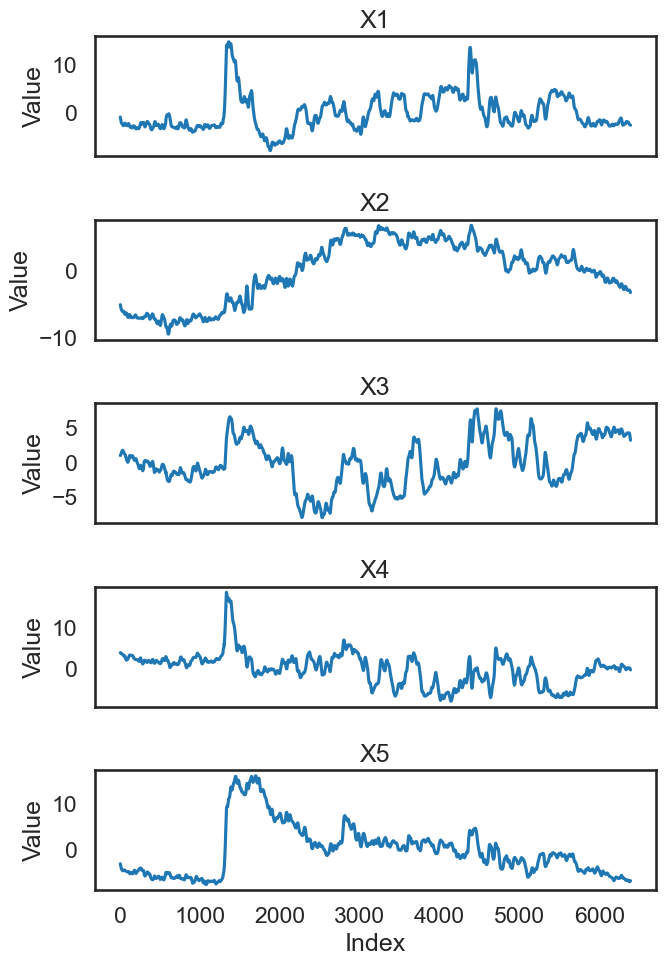

In [ ]:
fig, axs = plt.subplots(m1emissions.shape[1], figsize=(7, 2*m1emissions.shape[1]+1))

for i in range(m1emissions.shape[1]):
    axs[i].plot(m1emissions[:, i])
    axs[i].set_title(f'X{i+1}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')
    if i < 4:
        axs[i].set_xticks([])
        axs[i].set_xlabel('')

plt.tight_layout()
plt.show()

In [ ]:
# PLS Regression
# Resample the dimension to the target length
X = neuraldata
y_emit = m1emissions[:, 1]
x = np.linspace(0, 1, len(y_emit))
x_new = np.linspace(0, 1, 8153) # Create a new x array for the target length
y = np.interp(x_new, x, y_emit) # Use numpy.interp to interpolate the y values

# Plot the resampled dimension
plt.figure(figsize=(10, 3))
plt.plot(y, label='Resampled')
plt.title('Resampled X2')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

NameError: name 'neuraldata' is not defined

In [ ]:
# Create and fit the PLS model
pls = PLSRegression(n_components=2)
pls.fit(X, y)

# Get the latent integration dimension
PLSdimension = pls.transform(X)

# Evaluate the PLS model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict the target values using the PLS model
y_pred = pls.predict(X)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate the MAE
mae = mean_absolute_error(y, y_pred)

# Calculate the R^2 score
r2 = r2_score(y, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

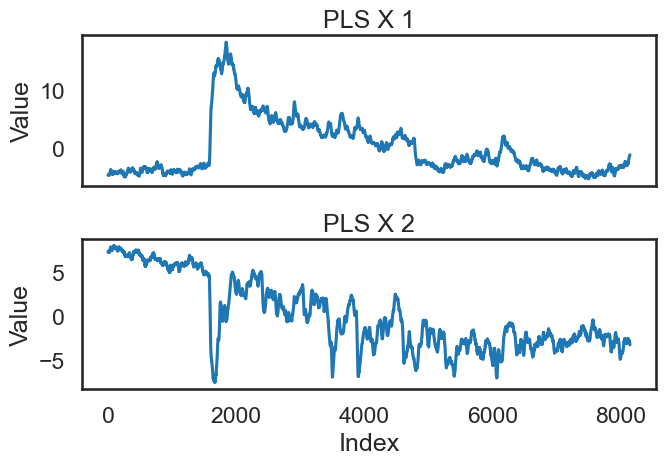

In [ ]:
# Plot the PLS dimensions
fig, axs = plt.subplots(2, figsize=(7, 5))

for i in range(2):
    axs[i].plot(PLSdimension[:, i])
    axs[i].set_title(f'PLS X {i+1}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')

axs[0].set_xticks([])
axs[0].set_xlabel('')
plt.tight_layout()
plt.show()

#### Artificial dimensions

In [ ]:
# Create a step function for the novelty dimension
# Find the index of the first behavior occurrence
start_index = np.argmax(statedatapy != 0)

# Create the noveltydim array
noveltydim = np.zeros_like(statedatapy)
end_index = start_index + 100

# Ensure end_index doesn't exceed the length of the array
if end_index > len(statedatapy):
    end_index = len(statedatapy)

# Set noveltydim to 1 starting from the first behavior occurrence and lasting for 100 frames
noveltydim[start_index:end_index] = 1

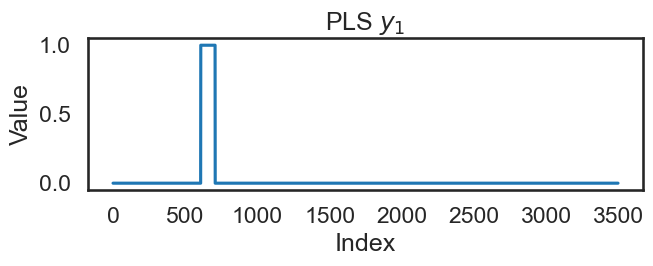

In [ ]:
y = noveltydim.T
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

ax.plot(y)
ax.set_title('PLS $y_1$')
ax.set_xlabel('Index')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
# Find the index of the first eating behavior
start_behavior = np.argmax(statedatapy != 0)

# Find the index of the first eating behavior
start_eating = np.argmax(statedatapy == 2)

# Create the new variable
intdim = np.zeros_like(statedatapy, dtype=float)

# Ensure start_eating is after start_behavior and it exists
if start_eating > start_behavior and start_eating > 0:
    intdim[start_behavior:start_eating] = np.linspace(0, 1, start_eating - start_behavior)
    intdim[start_eating:] = 1

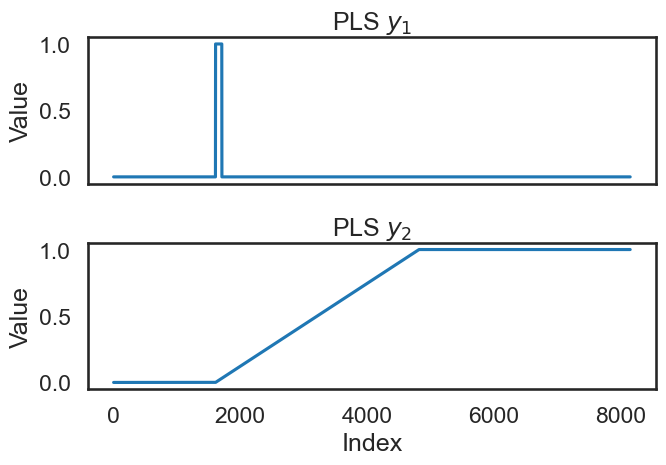

In [ ]:
y = np.vstack((noveltydim, intdim)).T
fig, axs = plt.subplots(2, figsize=(7, 5))

for i in range(2):
    axs[i].plot(y[:, i])
    axs[i].set_title(f'PLS $y_{i+1}$')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')

axs[0].set_xticks([])
axs[0].set_xlabel('')
plt.tight_layout()
plt.show()

In [ ]:
# PLS Regression
# Define the data and target
X = neuraldata

# Create and fit the PLS model
pls = PLSRegression(n_components=2)
pls.fit(X, y)

# Get the latent integration dimension
PLSdimension = pls.transform(X)

# Evaluate the PLS model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict the target values using the PLS model
y_pred = pls.predict(X)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate the MAE
mae = mean_absolute_error(y, y_pred)

# Calculate the R^2 score
r2 = r2_score(y, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

RMSE: 0.09942685381668662
MAE: 0.06094192642181162
R^2: 0.6438240707835632


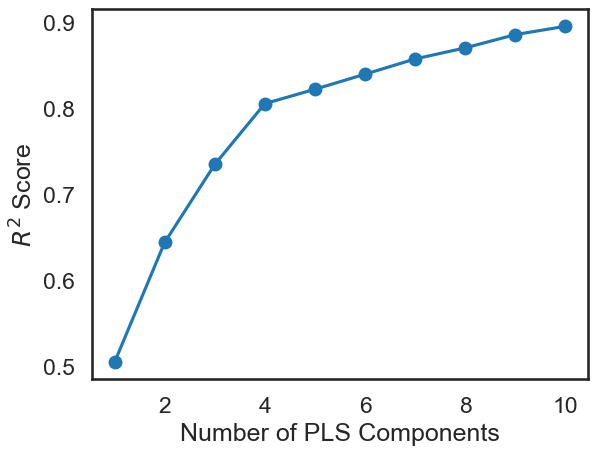

In [ ]:
# Define the range of components to test
components = range(1, 11)

# Initialize a list to store the R^2 scores
r2_scores = []

# Loop over the components
for n in components:
    # Create and fit the PLS model
    pls = PLSRegression(n_components=n)
    pls.fit(X, y)

    # Predict the target values using the PLS model
    y_pred = pls.predict(X)

    # Calculate the R^2 score and append it to the list
    r2 = r2_score(y, y_pred)
    r2_scores.append(r2)

# Plot the R^2 scores against the number of components
plt.plot(components, r2_scores, marker='o')
plt.xlabel('Number of PLS Components')
plt.ylabel('$R^2$ Score')
plt.show()

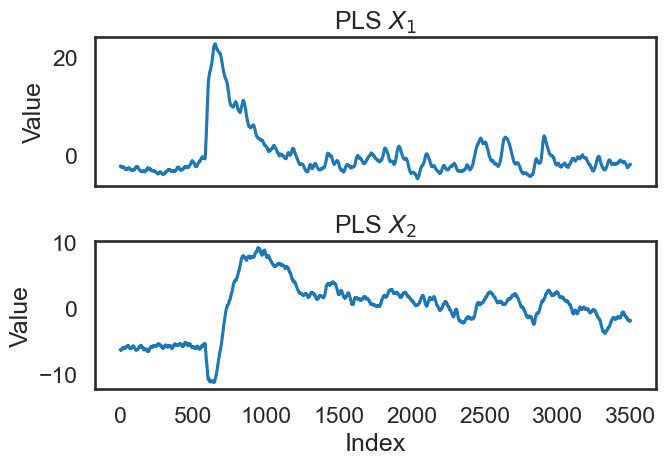

In [ ]:
# Plot the PLS dimensions
fig, axs = plt.subplots(PLSdimension.shape[1], figsize=(7, 2*PLSdimension.shape[1]+1))

for i in range(PLSdimension.shape[1]):
    axs[i].plot(PLSdimension[:, i])
    axs[i].set_title(f'PLS $X_{i+1}$')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')
    if i < PLSdimension.shape[1]-1:
        axs[i].set_xticks([])
        axs[i].set_xlabel('')

plt.tight_layout()
plt.show()

##### PLS dimensions on full session

In [ ]:
# Load full session data
vmhdata = loadmat('data/EG1-4_fasted_unreg_rSLDS.mat')
neuraldata = np.transpose(vmhdata['neuralDataPreprocessed'])
statedata = vmhdata['collapsedBehaviorData']

statedatapy = statedata[0,:]

# PLS transform the full session data
PLSdimensionfull = pls.transform(neuraldata)

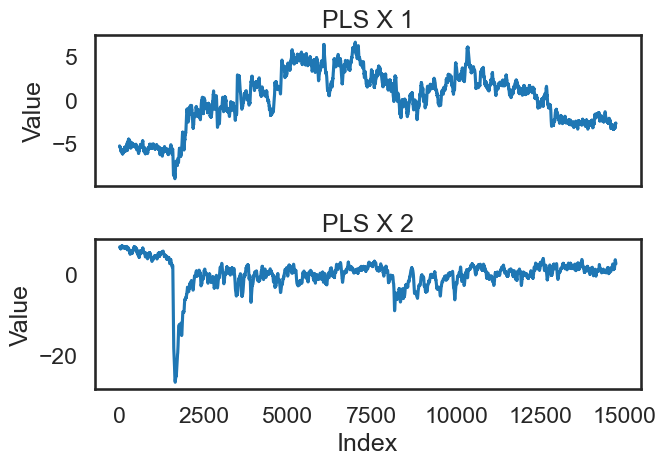

In [ ]:
# Plot the PLS dimensions for full session
fig, axs = plt.subplots(2, figsize=(7, 5))

for i in range(2):
    axs[i].plot(-PLSdimensionfull[:, i])
    axs[i].set_title(f'PLS X {i+1}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')

axs[0].set_xticks([])
axs[0].set_xlabel('')
plt.tight_layout()
plt.show()

## rSLDS

In [ ]:
# Fit model using Laplace-EM (without inputs)
# l2_penalty params act as regularizers for the factor analysis and AR-HMM steps in rSLDS
rSLDSdata = neuraldata
K = 3 # number of discrete states
D_latent = 2 # number of latent dimensions
D_obs = rSLDSdata.shape[1] # number of observed dimensions (N)

print("Fitting SLDS with Laplace-EM")

rslds = ssm.SLDS(D_obs, K, D_latent,
                 transitions="recurrent_only",
                 dynamics="gaussian",
                 emissions="gaussian_id",
                 single_subspace=True,
                 dynamics_kwargs=dict(l2_penalty_A=100),
                 transitions_kwargs=dict(l2_penalty=500)
                 )

rslds.initialize(rSLDSdata) # Not sure what this does

# Fit the model using Laplace-EM with a structured variational posterior
# alpha term weights the evidence for each iteration of the model

q_elbos_lem, q_lem = rslds.fit(rSLDSdata, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=150, alpha=0.9)

Fitting SLDS with Laplace-EM


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Find the permutation that matches the true and inferred states
xhat_lem = q_lem.mean_continuous_states[0] # Get the posterior mean of the continuous states
# rslds.permute(find_permutation(statedatapyfsubfl, rslds.most_likely_states(xhat_lem, neuraldatasub)))
zhat_lem = rslds.most_likely_states(xhat_lem, rSLDSdata) # Get the most likely states

In [ ]:
# Save learned model
# rslds.q_elbos_lem = q_elbos_lem
# rslds.xhat_lem = xhat_lem
# rslds.zhat_lem = zhat_lem
# file_rslds = open('model/rslds_model_5dim_EG1-4_fasted_unreg_male1only.obj', 'wb')
# pickle.dump(rslds, file_rslds)

In [112]:
# Load learned model
file_rslds = open('model/rslds_model_EG1-4_fasted_unreg_male1.obj', 'rb') 
rslds = pickle.load(file_rslds)
q_elbos_lem = rslds.q_elbos_lem
xhat_lem = rslds.xhat_lem
zhat_lem = rslds.zhat_lem

In [113]:
rslds_lem = copy.deepcopy(rslds) # Store rslds

### ELBO

In [114]:
%matplotlib inline

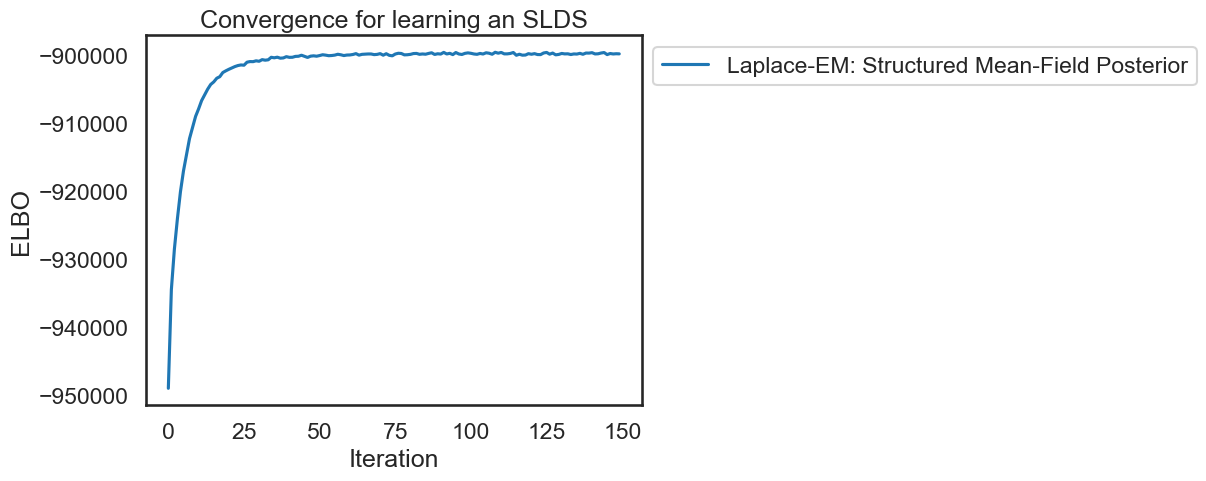

In [115]:
# Plot ELBO (Log Likelihood) 
# plt.plot(q_elbos_bbvi, label="BBVI")
plt.plot(q_elbos_lem[1:], label="Laplace-EM: Structured Mean-Field Posterior")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.title("Convergence for learning an SLDS")
plt.show()

### State transitions

In [116]:
statedatapy.shape

(8153,)

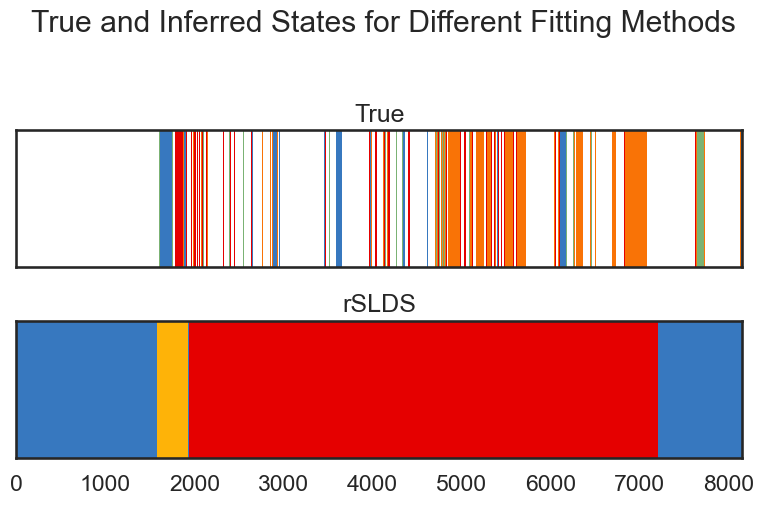

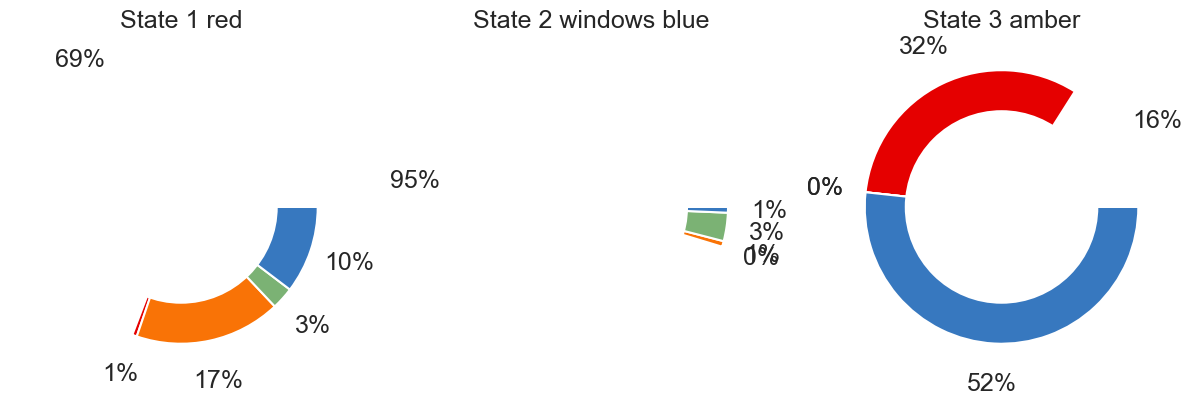

In [117]:
# Plot the true and inferred states
# true states refer to the behs given by the yser
cmap_limited = ListedColormap(colors[0:rslds_lem.K])

titles = ["True", "rSLDS", "SVI with Structured MF", "SVI with MF"]
states_list = [statedatapy, zhat_lem]
fig, axs = plt.subplots(2, 1, figsize=(8,5))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    if i == 1:
        ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    else:
        ax.imshow(states[None,:], aspect="auto", cmap=cmap_beh)
    ax.set_yticks([])
    ax.set_title(titles[i])
    if i < (len(axs) - 1):
        ax.set_xticks([])

plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()

plot_state_pie(zhat_lem, rslds_lem, statedatapy, figsize=(15,5))

# plt.savefig("~path/state_comp.svg")
# mdic = {"discrete_state": zhat_lem, "label": "Mouse_2"}
# savemat("~path/discrete_states.mat", mdic)

([<matplotlib.axis.YTick at 0x1cc21a470a0>,
 [Text(0, 0, '0'), Text(0, 1, '1'), Text(0, 2, '2')])

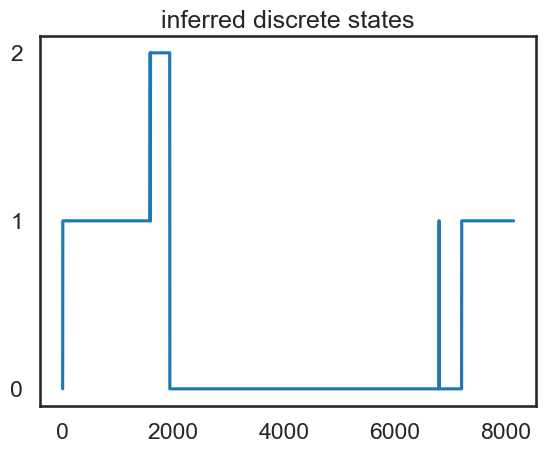

In [118]:
# Plot the learned discrete states
plt.title("inferred discrete states")
plt.plot(zhat_lem)
plt.yticks(np.arange(rslds_lem.K))

[53.979433 53.979433]
[323.25022769  52.82111358]
[14.2224129 14.2224129]


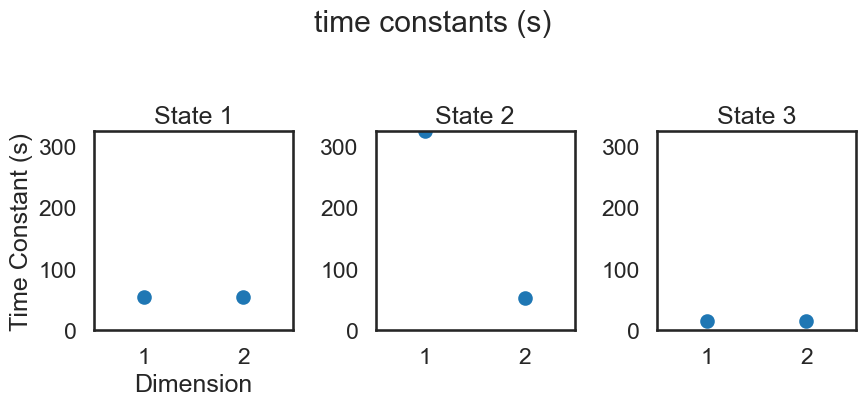

In [119]:
# Plot time constants (from eigenvalues of dynamics matrix)
# Initialize global min and max
global_max = -np.inf

fig, axs = plt.subplots(1, rslds_lem.K, figsize=(3*rslds_lem.K, 4))
for (k, ax) in enumerate(axs):
    w, v = np.linalg.eig(rslds_lem.dynamics.As[k,:,:])
    time_const_w = (np.abs(1/np.log(np.abs(w))))/10
    x_pos = range(1, rslds_lem.D+1)
    ax.scatter(x_pos, time_const_w)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(range(1, rslds_lem.D+1))
    ax.set_xlim([0.5, rslds_lem.D+0.5])
    if k == 0:
        ax.set_xlabel('Dimension')
        ax.set_ylabel('Time Constant (s)')
    print(time_const_w)
    ax.set_title(f'State {k+1}')

    # Update global min and max
    current_max =np.max(time_const_w)
    global_max = max(global_max, current_max)

# Set the same y limit for all plots
for ax in axs:
    ax.set_ylim([0, global_max])

plt.suptitle("time constants (s)", va="baseline")
plt.tight_layout()

### Latent factors

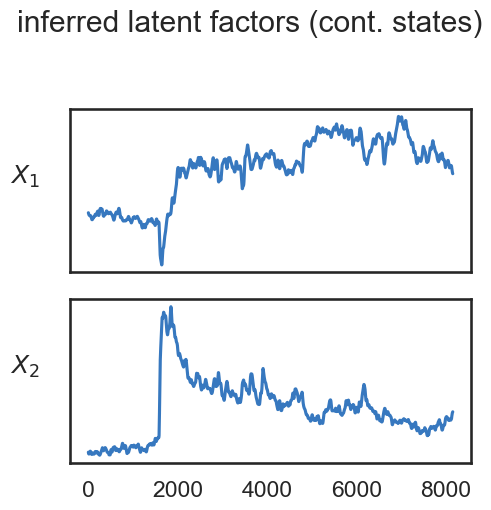

In [120]:
# Plot continous states (latent factors) 
fig, axs = plt.subplots(rslds_lem.D, 1, figsize=(5, 2*rslds_lem.D+1))
for (d, ax) in enumerate(axs):
    ax.plot(xhat_lem[:,d] + 4 * d, '-', color=colors[1], label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(f'$X_{d+1}$', loc="left", y=0.5, x=-0.15)
    if d != rslds_lem.D-1: ax.set_xticks([])
# axs[0].legend(loc="upper right")

plt.suptitle("inferred latent factors (cont. states)", va="bottom")
plt.tight_layout()

In [121]:
# Specify colors for plotting behaviors
color_names_beh = ["white",
                   "red",
                   "orange",
                   "faded green",
                   "windows blue"]
colors_beh = sns.xkcd_palette(color_names_beh[0:])
cmap_beh = ListedColormap(colors_beh)

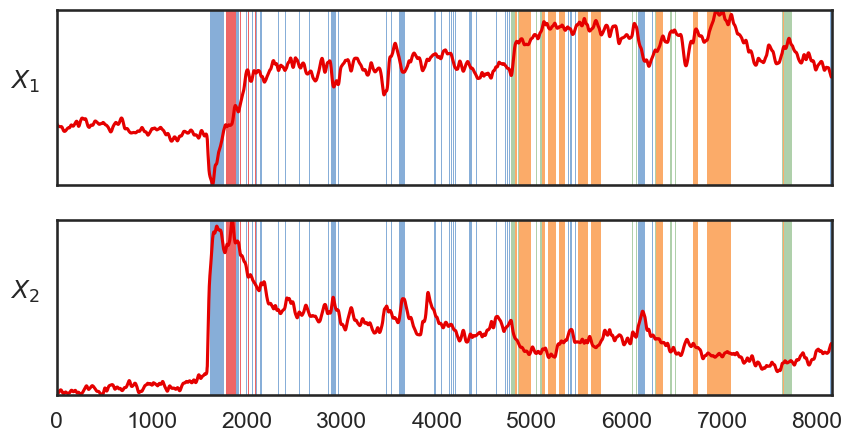

In [122]:
fig, axs = plt.subplots(rslds_lem.D, 1, figsize=(10, 2*rslds_lem.D+1))
for (d, ax) in enumerate(axs):
    ax.plot(sklearn.preprocessing.minmax_scale(-xhat_lem[:,d], feature_range=(-0.5,0.5)), '-', color=colors[0], label="Laplace-EM" if d==0 else None)
    ax.imshow(statedatapy[None,:], aspect="auto", cmap=cmap_beh, alpha = 0.6, interpolation ='nearest')
    ax.set_yticks([])
    ax.set_title(f'$X_{d+1}$', loc="left", y=0.5, x=-0.06)
    if d != rslds_lem.D-1: ax.set_xticks([])
# axs[0].legend(loc="upper right")

### Flow fields

In [123]:
# Set colors for plotting flow fields in rSLDS
color_names_state = ["orange",
                     "dusty purple",
                     "blue green",
                     "dusty purple",]
colors_state_dynamics = sns.xkcd_palette(color_names_state)
cmap_limited_state = ListedColormap(colors_state_dynamics[0:])

In [124]:
colors_state_dynamics = colors[0:rslds_lem.K]

In [125]:
# Reset colors for behs to show in flow field
color_names_traj = ["black",
                    "red",
                    "orange",
                    "faded green",
                    "windows blue"]
colors_traj = sns.xkcd_palette(color_names_traj[0:])
cmap_limited_traj = ListedColormap(colors_traj)

<Axes: title={'center': 'flow field and neural trajectories'}, xlabel='$x_1$', ylabel='$x_2$'>

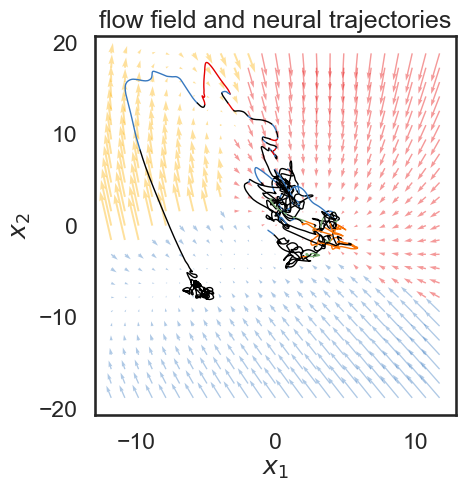

In [126]:
# Plot beh-defined trajectories on top of the flow-field
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), nxpts=25, nypts=25, ax=ax, alpha=0.4)
plt.title("flow field and neural trajectories")

plot_trajectory_beh(statedatapy, xhat_lem, 0, 1, ax=ax)

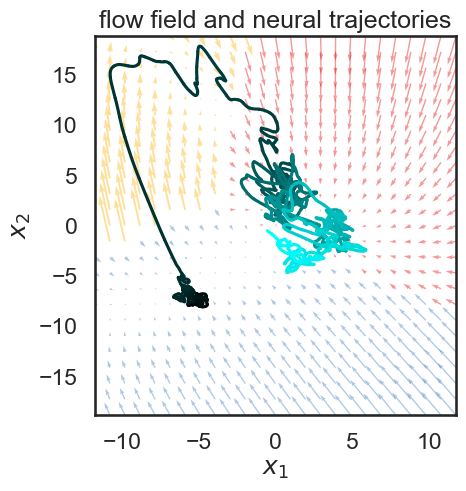

In [127]:
# Plot trajectories over time on top of the flow-field
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), nxpts=25, nypts=25,ax=ax,alpha = 0.4)
plt.title("flow field and neural trajectories")
# Prep data
n=len(xhat_lem)
x=xhat_lem[:,0]
y=xhat_lem[:,1]

# Your coloring array
T=np.linspace(0,1,np.size(x))

# Segment plot and color depending on T
s = 10 # Segment length
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1],y[i:i+s+1],color=(0.0,T[i],T[i]))
    ax.set_xlim([-lim[0], lim[0]])
    ax.set_ylim([-lim[1], lim[1]])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

### Model performance

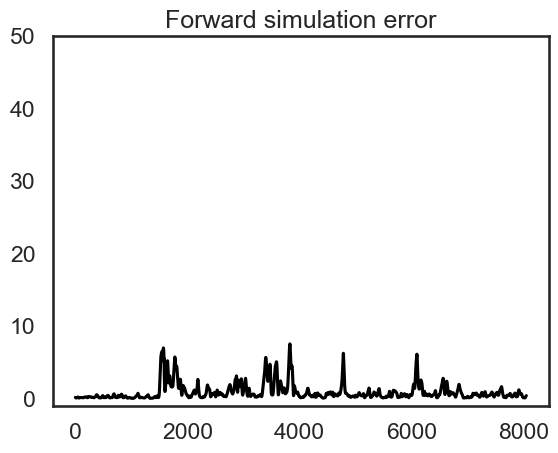

In [128]:
# Plot model performance on training data 
# forward simulation error
from sklearn.metrics import mean_squared_error

mse_all = []
startpoint = 1

for tini in range(startpoint, (len(xhat_lem)-100)):
    xinitial = xhat_lem[tini,:]
    pred_x = [xinitial]

    for t in range(tini,tini+100):
        state_id = zhat_lem[t]
        x_calc = pred_x[t-tini].dot(rslds_lem.dynamics.As[state_id,:,:].T) + rslds_lem.dynamics.bs[state_id,:]
        pred_x.append(x_calc)

    pred_x_arr = np.array(pred_x)
    real_x_arr = xhat_lem[tini:(tini+100+1),:]
    mse = mean_squared_error(real_x_arr, pred_x_arr)
    mse_all.append(mse)

mse_arr = np.array(mse_all)

plt.title("Forward simulation error")
plt.plot(mse_arr,'k')
ax = plt.gca()
ax.set_ylim([-1, 50])

mdic = {"perf": mse_arr, "label": "Mouse_1"}
# savemat("~path/performance.mat", mdic)

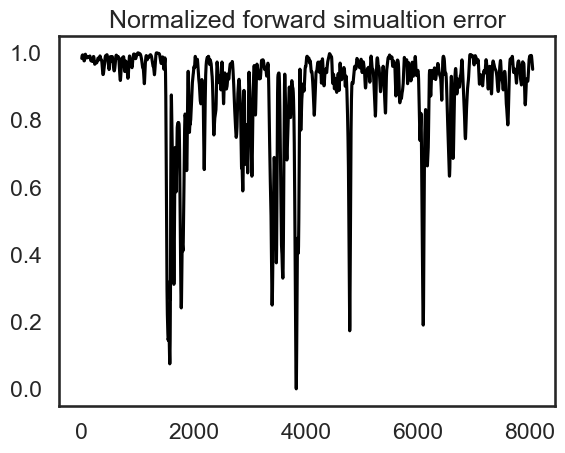

In [129]:
# plot normalized forward simulation error (as used in Liu, Nair et al.,)
mse_arr_norm = 1 - sklearn.preprocessing.minmax_scale(mse_arr, feature_range = (0,1))
plt.title("Normalized forward simualtion error")
plt.plot(mse_arr_norm,'k')
ax = plt.gca()
mdic = {"perf": mse_arr, "label": "Mouse_1"}
# plt.savefig("~path/model_performance.svg")

In [130]:
# Plot model performance on training data 
# predict neural trajectries forward in time

# calculate discrete states
startpoint = 1
xinitial = xhat_lem[startpoint,:]
pred_x = [xinitial]

for t in range(startpoint,len(xhat_lem)):
    z_calc = np.argmax(pred_x[t-startpoint].dot(rslds_lem.transitions.Rs.T) + rslds_lem.transitions.r, axis=0)
    x_calc = pred_x[t-startpoint].dot(rslds_lem.dynamics.As[z_calc,:,:].T) + rslds_lem.dynamics.bs[z_calc,:]
    pred_x.append(x_calc)

pred_x_arr_calc_state = np.array(pred_x)

In [131]:
# Plot model performance on training data 
# predict neural trajectries forward in time

# use given discrete states
startpoint = 1
xinitial = xhat_lem[startpoint,:]
pred_x = [xinitial]

for t in range(startpoint,len(xhat_lem)):
    state_id = zhat_lem[t]
    x_calc = pred_x[t-startpoint].dot(rslds_lem.dynamics.As[state_id,:,:].T) + rslds_lem.dynamics.bs[state_id,:]
    pred_x.append(x_calc)
    
pred_x_arr = np.array(pred_x)

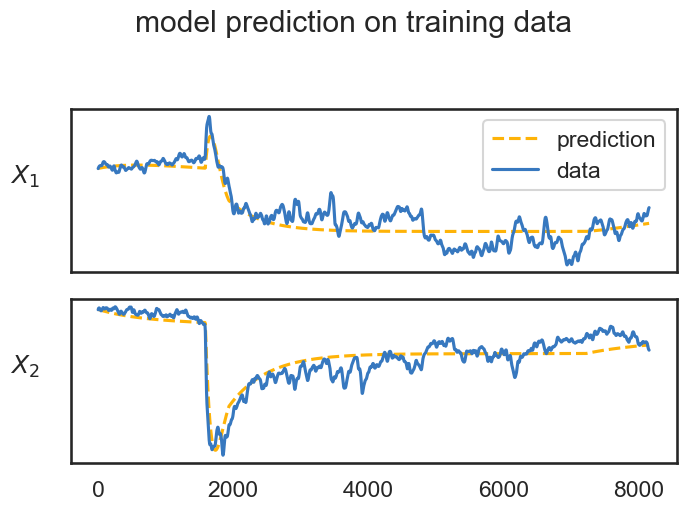

In [132]:
# Plot predicted continous states (latent factors) 
fig, axs = plt.subplots(rslds_lem.D, 1, figsize=(7, 2*rslds_lem.D+1))
for (d, ax) in enumerate(axs):
    ax.plot(-pred_x_arr[:,d] + 4*d, '--', color=colors[2], label="prediction" if d==0 else None)
    ax.plot(-xhat_lem[:,d] + 4*d, '-', color=colors[1], label="data" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(f'$X_{d+1}$', loc="left", y=0.5, x=-0.1)
axs[0].set_xticks([])
axs[0].legend(bbox_to_anchor=(1.0,1.0))

plt.suptitle("model prediction on training data", va="bottom")
plt.tight_layout()

# plt.savefig("~path/cont_states.svg")
# mdic = {"cont_states": xhat_lem, "label": "Mouse_2"}
# # savemat("~path/cont_states.mat", mdic)

<Axes: title={'center': 'Inferred Dynamics with flow field'}, xlabel='$x_1$', ylabel='$x_2$'>

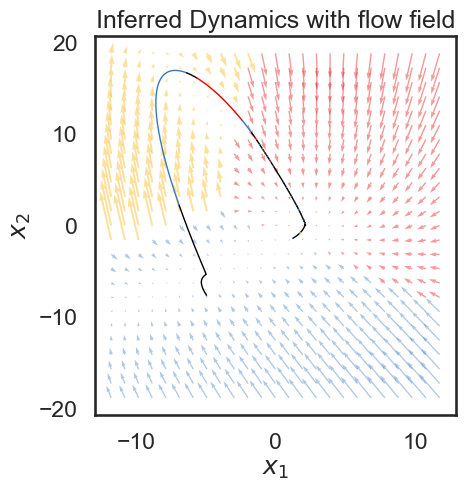

In [133]:
# show predicted trajectories in flow field
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), nxpts=25, nypts=25,ax=ax,alpha = 0.4)
plt.title("Inferred Dynamics with flow field")

# plot_trajectory_beh(statedatapy, xhat_lem,0,1,ax = ax)
plot_trajectory_beh(statedatapy, pred_x_arr,0,1,ax = ax)

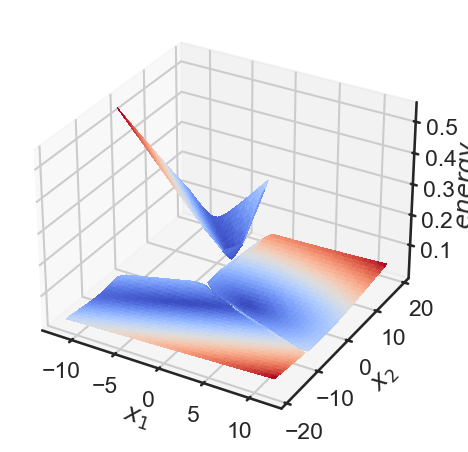

In [134]:
# Plot 3D dynamics velocity landscape
from matplotlib import cm
# %matplotlib qt

model = rslds_lem
xlim=(-lim[0], lim[0])
ylim=(-lim[1], lim[1])
nxpts=40
nypts=40
alpha=0.8
ax=None
figsize=(5, 5)

K = model.K
assert model.D == 2
x = np.linspace(*xlim, nxpts)
y = np.linspace(*ylim, nypts)
X, Y = np.meshgrid(x, y)
xy = np.column_stack((X.ravel(), Y.ravel()))

# Get the probability of each state at each xy location
z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

if ax is None:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

model.dynamics.As = model.dynamics.As[:,:,:]
model.dynamics.bs = model.dynamics.bs[:,:]

for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
#         dxydt_m = (xy**2).dot((A/2).T) + b - xy # plots energy
        dxydt_m = (xy).dot((A).T) + b - xy # plots dynamic velocity

        dxydt_m_norm = np.zeros((len(dxydt_m)))

        for xt in range(0,len(dxydt_m)): 
            dxydt_m_norm[xt] = np.linalg.norm(dxydt_m[xt,:])

        zk = z == k
        if zk.sum(0) > 0:

            ax.plot_trisurf(xy[zk, 0], xy[zk, 1], dxydt_m_norm[zk], cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$energy$')

plt.tight_layout()

In [135]:
# Training R2 of model
from scipy import stats

resdim1 = stats.linregress(xhat_lem[:,0], pred_x_arr[:,0])
resdim2 = stats.linregress(xhat_lem[:,1], pred_x_arr[:,1])
resr2 = (resdim1.rvalue**2 + resdim2.rvalue**2)/2
resr2

0.8581004025437897